# Analyse de l’action Amazon.com, Inc.

## Extraction des Données Historiques d'AMAZON avec yfinance et pandas

In [48]:
import yfinance as yf
import pandas as pd

# Définir le symbole de l'action pour AMAZON
ticker_symbol = "AMZN"

# Définir les dates de début et de fin pour les données
start_date = "2019-12-22"
end_date = "2023-12-22"

# Récupérer les données historiques en utilisant yfinance
amazon_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Afficher les premières lignes des données
print(amazon_data.head())
len(amazon_data)


[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-12-23  89.413002  89.650002  89.225502  89.650002  89.650002   42728000
2019-12-24  89.690498  89.778503  89.378998  89.460503  89.460503   17626000
2019-12-26  90.050499  93.523003  89.974998  93.438499  93.438499  120108000
2019-12-27  94.146004  95.070000  93.300499  93.489998  93.489998  123732000
2019-12-30  93.699997  94.199997  92.030998  92.344498  92.344498   73494000


1007

## Analyse Visuelle des Données de Prix de Clôture d'Amazon : Série Temporelle, Autocorrélation et Autocorrélation Partielle

<ipython-input-13-188e5eabd27f>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Utilisation d'un style seaborn pour les graphiques


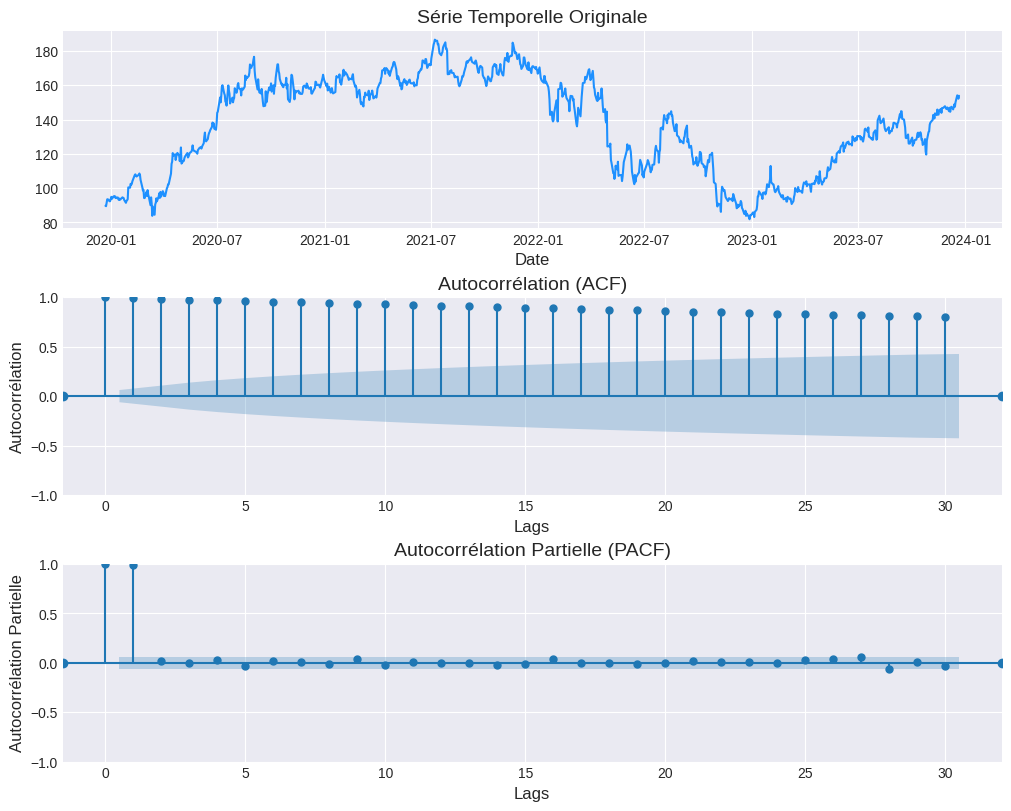

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_time_series_analysis(data):
    """
    Plot the original time series data, ACF and PACF for the given column of the DataFrame.

    :param data: pandas DataFrame containing the time series data.
    """
    # Configuration de l'apparence des graphiques
    plt.style.use('seaborn-darkgrid')  # Utilisation d'un style seaborn pour les graphiques
    plt.rcParams.update({'figure.figsize': (12, 12)})
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), dpi=100, constrained_layout=True)

    # Série originale
    axes[0].plot(data, color='dodgerblue', linestyle='-', markersize=4)
    axes[0].set_title('Série Temporelle Originale', fontsize=14)
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].grid(True)

    # Autocorrélation
    plot_acf(data, ax=axes[1], lags=30, alpha=0.05, use_vlines=True, marker='o')
    axes[1].set_title('Autocorrélation (ACF)', fontsize=14)
    axes[1].set_xlabel('Lags', fontsize=12)
    axes[1].set_ylabel('Autocorrélation', fontsize=12)
    axes[1].grid(True)

    # Autocorrélation partielle
    plot_pacf(data, ax=axes[2], lags=30, alpha=0.05, use_vlines=True, marker='o')
    axes[2].set_title('Autocorrélation Partielle (PACF)', fontsize=14)
    axes[2].set_xlabel('Lags', fontsize=12)
    axes[2].set_ylabel('Autocorrélation Partielle', fontsize=12)
    axes[2].grid(True)

    plt.show()
plot_time_series_analysis(amazon_data['Close'])


### **La série originale**
#### Le graphique montre une tendance haussière initiale suivie d'un recul marqué et d'une période de stabilisation. Une volatilité notable apparaît ensuite, reflétant une incertitude du marché. Finalement, on assiste à une reprise positive vers la fin de la période étudiée.

### **Autocorrélation**
#### Forte autocorrélation initiale qui diminue progressivement, suggérant un fort effet de mémoire à court terme où les prix passés influencent fortement les prix futurs.

### **Autocorrélation partielle**
#### Un pic significatif au premier lag indique une forte autocorrélation partielle immédiate, après quoi la PACF tombe rapidement sous le seuil de signification. Les lags suivant le premier montrent des autocorrélations partielles proches de zéro, ce qui suggère que les valeurs de prix antérieures n'ont pas d'influence directe significative sur les valeurs futures au-delà du premier décalage.





## Graphiques de Moyenne et Écart-type Mobiles

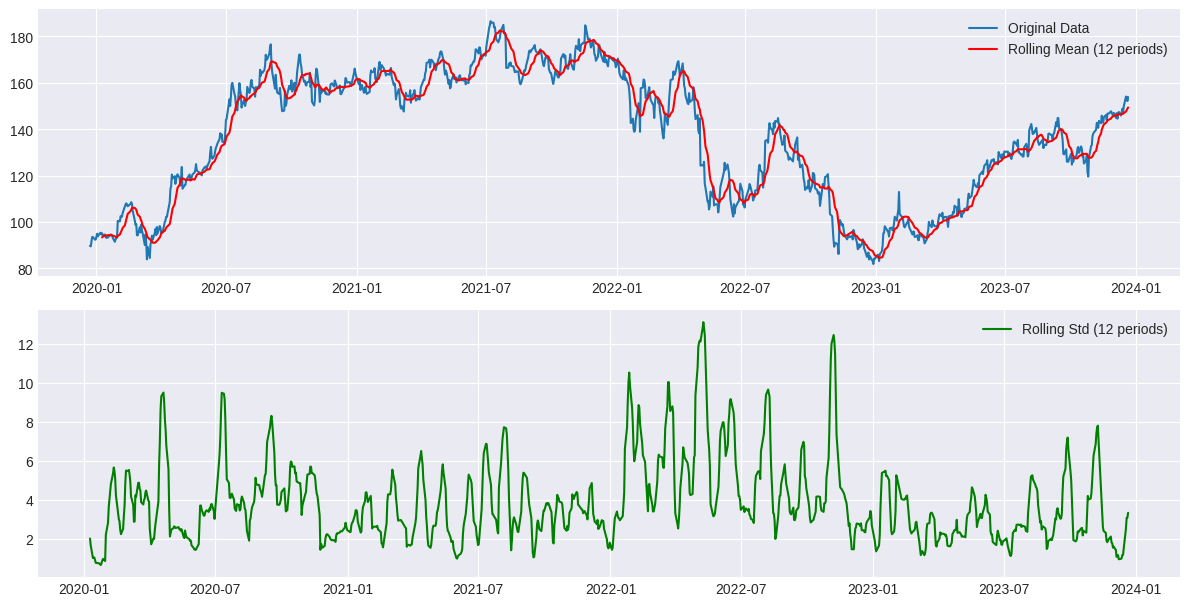

In [14]:
import matplotlib.pyplot as plt

def plot_rolling_statistics(data, window_size=12):
    """
    Plot the original data, rolling mean, and rolling standard deviation of a time series.

    Parameters:
    - data: A Data containing the time series data.
    - window_size: The size of the rolling window (default is 12).
    """
    # Extract the time series data
    y = data

    # Calculate rolling statistics
    rolling_mean = y.rolling(window=window_size).mean()
    rolling_std = y.rolling(window=window_size).std()

    # Set a larger figure size
    plt.figure(figsize=(12, 12))

    # Plot the original data
    plt.subplot(4, 1, 1)
    plt.plot(y, label='Original Data')
    plt.legend(loc='best')

    # Plot the rolling mean
    plt.subplot(4, 1, 1)
    plt.plot(rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='red')
    plt.legend(loc='best')

    # Plot the rolling standard deviation
    plt.subplot(4, 1, 2)
    plt.plot(rolling_std, label=f'Rolling Std ({window_size} periods)', color='green')
    plt.legend(loc='best')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()


plot_rolling_statistics(amazon_data['Close'], window_size=12)


*   Le deuxième graphique affiche la moyenne mobile sur 12 périodes, qui souligne la tendance générale de la série temporelle. Il est visible que la moyenne mobile change avec le temps, indiquant une non-stationnarité de la tendance.
*   Le troisième graphique dépeint l'écart-type mobile, et il est apparent que la volatilité change également au fil du temps, ce qui est une autre indication de non-stationnarité.

## Graphiques de Décomposition Saisonnière

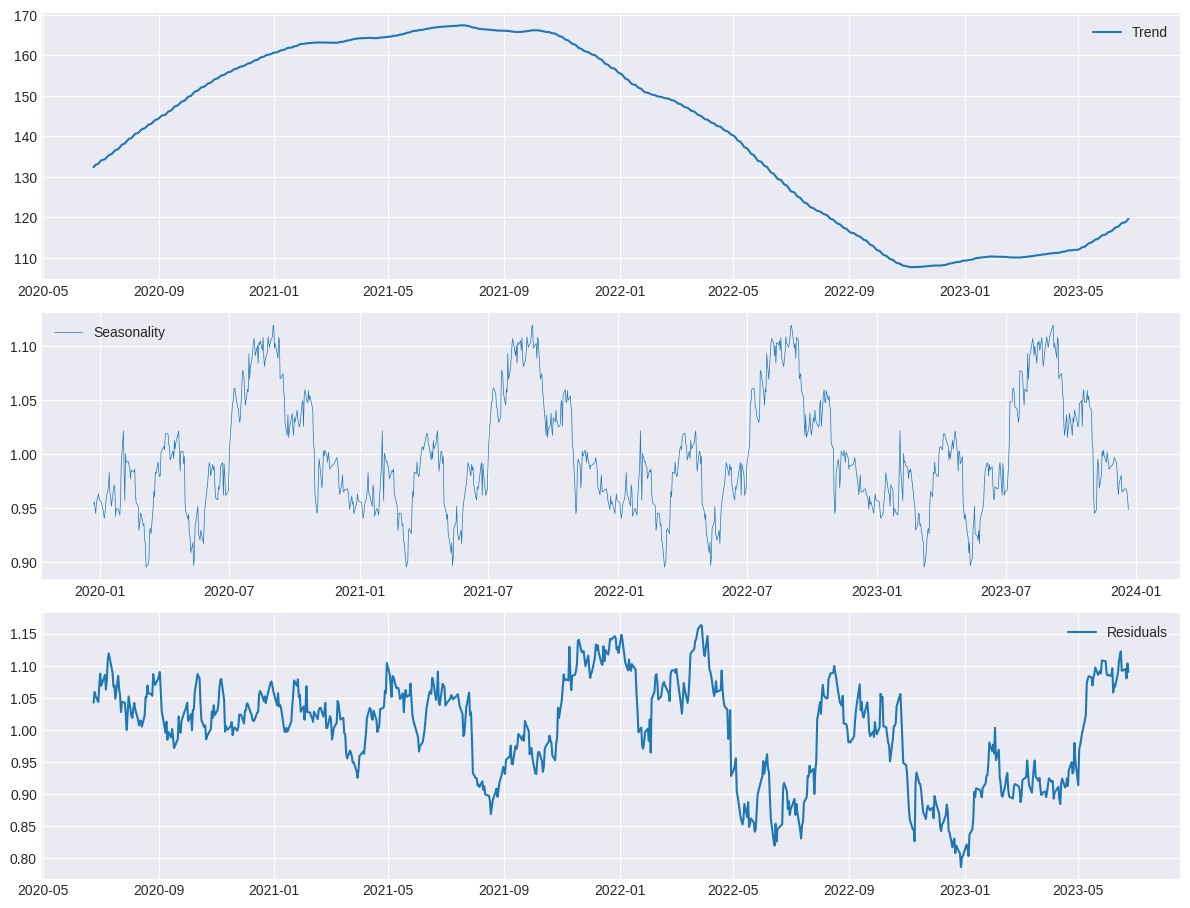

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def plot_seasonal_decomposition(data, decomposition_period=252, model='multiplicative'):
    """
    Perform and plot seasonal decomposition of time series data.

    Parameters:
    - data: A Data containing the time series data.
    - decomposition_period: The periodicity of the time series.
    - model: The type of decomposition model ('multiplicative' or 'additive'). Default is 'multiplicative'.
    """
    # Extract the time series data
    y = data

    # Perform seasonal decomposition
    result = seasonal_decompose(y, model=model, period=decomposition_period)

    # Set a larger figure size
    plt.figure(figsize=(12, 12))

    # Plot the decomposed components

    plt.subplot(4, 1, 1)
    plt.plot(result.trend, label='Trend')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(result.seasonal, label='Seasonality', linewidth=0.5)
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(result.resid, label='Residuals')
    plt.legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()


plot_seasonal_decomposition(data=amazon_data['Close'])


*   La deuxième graphique indique la tendance extraite de la série temporelle. La présence d'une tendance ascendante puis descendante confirme une non-stationnarité de la série, car la moyenne n'est pas constante dans le temps.

*   La troisième graphique montre la composante saisonnière, qui semble présenter des motifs répétitifs, suggérant une saisonnalité dans les données.



## Résultats du Test ADF :

In [16]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'amazon_data' is your DataFrame and it contains a 'Close' column for the closing prices
y = amazon_data['Close']

# Perform the Dickey-Fuller test
adf_test = adfuller(y, autolag='AIC')  # 'AIC' will choose the best lag based on information criteria

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

# Interpretation
if adf_test[1] < 0.05:
    print("La série est stationnaire avec un seuil de confiance de 95%.")
else:
    print("La série n'est pas stationnaire")


ADF Statistic: -2.1386837736273616
p-value: 0.22924672977058935
Critical Values:
   1%, -3.436866962597422
Critical Values:
   5%, -2.864417284603703
Critical Values:
   10%, -2.5683020002450507
La série n'est pas stationnaire


*   La statistique ADF de -2.1387 est supérieure aux valeurs critiques à 1%, 5% et 10%, ce qui signifie que nous ne pouvons pas rejeter l'hypothèse nulle de non-stationnarité à ces niveaux de significativité.
*   Ces résultats suggèrent que la série temporelle possède une ou plusieurs racines unitaires, indiquant que la série est non-stationnaire.
*   La valeur p de 0.2292 est supérieure au seuil habituel de 0.05, ce qui renforce l'acceptation de l'hypothèse nulle de non-stationnarité.



## Interprétation Globale :
La série temporelle des prix de clôture d'Amazon n'est pas stationnaire. Elle présente des changements dans la moyenne et la volatilité au fil du temps ainsi qu'une tendance et une saisonnalité évidentes. Les résultats du test ADF confirment cette non-stationnarité.

# L'ordre de différenciation (d) dans le modèle ARIMA

ADF Statistic for original series: -2.1386837736273616
p-value for original series: 0.22924672977058935
ADF Statistic for 1° differenced series: -32.551705957089794
p-value for 1° differenced series: 0.0
Order of differentiation (d) needed: 1


<ipython-input-13-188e5eabd27f>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Utilisation d'un style seaborn pour les graphiques


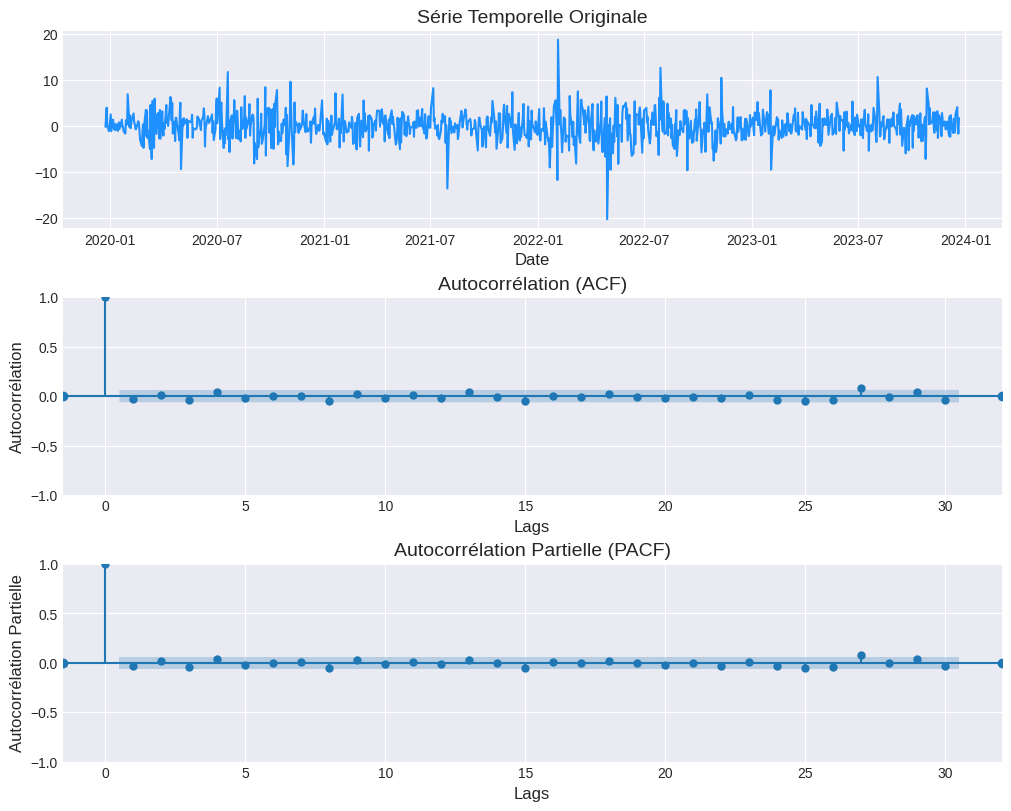

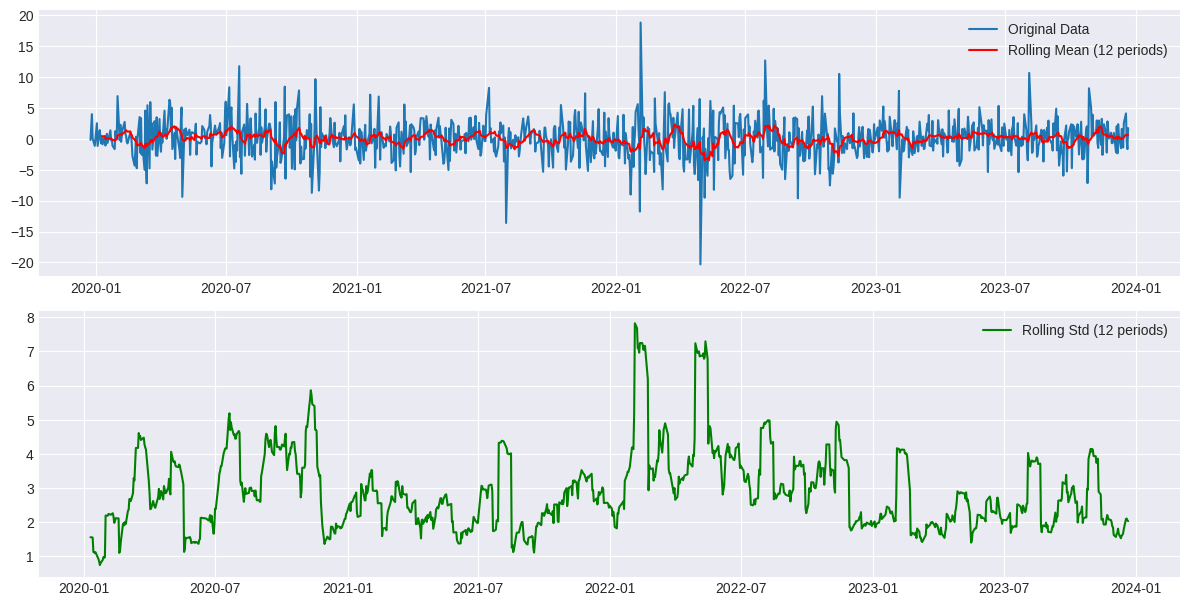

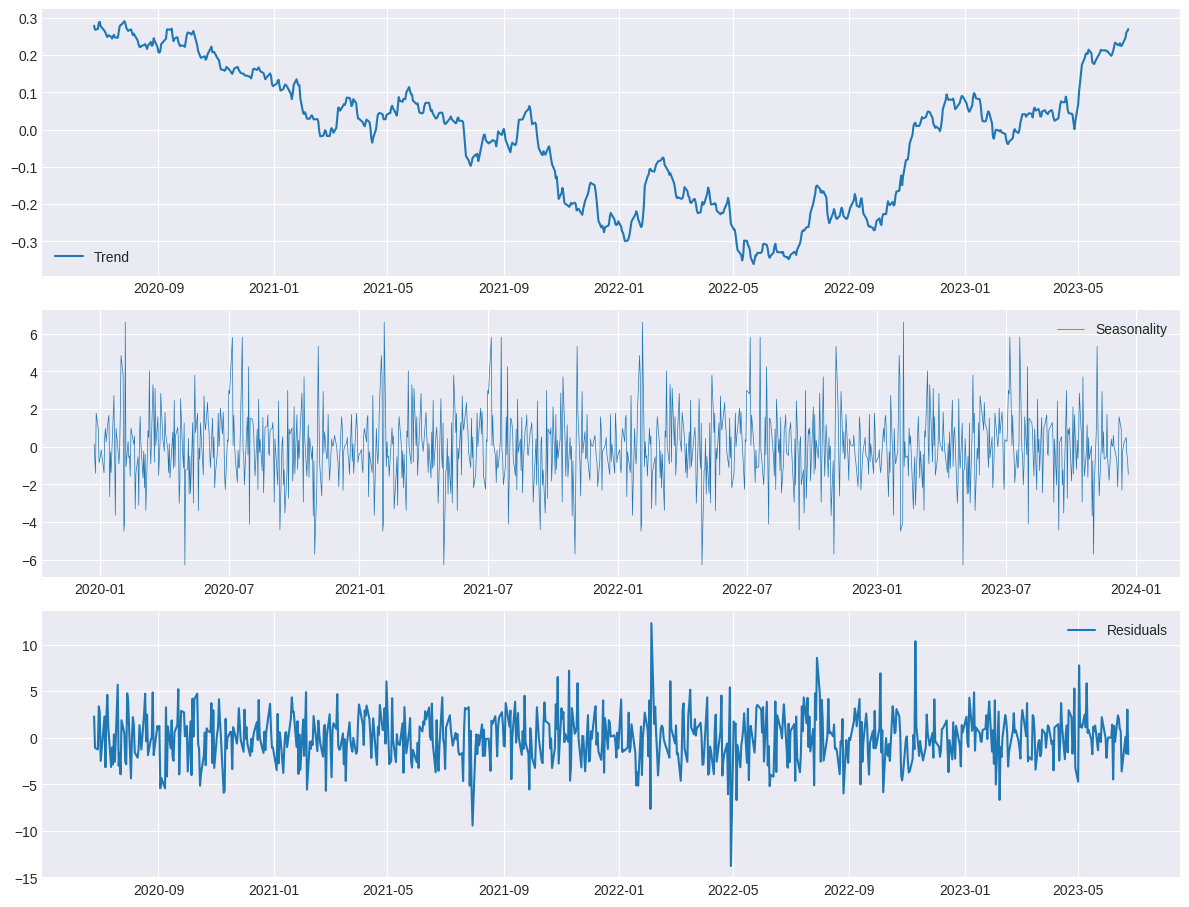

In [17]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def find_order_of_differentiation(series):
    # Test de stationnarité
    adf_test = adfuller(series, autolag='AIC')
    print(f'ADF Statistic for original series: {adf_test[0]}')
    print(f'p-value for original series: {adf_test[1]}')

    d = 0
    # Si la série n'est pas stationnaire, on différencie jusqu'à ce qu'elle le devienne
    while adf_test[1] > 0.05:
        d += 1
        series = series.diff().dropna()
        adf_test = adfuller(series, autolag='AIC')
        print(f'ADF Statistic for {d}° differenced series: {adf_test[0]}')
        print(f'p-value for {d}° differenced series: {adf_test[1]}')

    print(f'Order of differentiation (d) needed: {d}')

    return d, series


d, amazon_data_diff_d = find_order_of_differentiation(amazon_data['Close'])

plot_time_series_analysis(amazon_data_diff_d)
plot_rolling_statistics(amazon_data_diff_d, window_size=12)
plot_seasonal_decomposition(amazon_data_diff_d,model='additive')

## D'après les graphiques au dessus :



*   La série différencie d'ordre 1 montre une fluctuation autour de zéro sans tendance visible, ce qui est une indication de stationnarité.
*   La moyenne mobile et l'écart-type mobile, qui semblent osciller autour d'une moyenne constante sans tendance ou variation systématique dans leur amplitude, suggèrent également une stationnarité
*   Les valeurs d'autocorrélation (ACF) et d'autocorrélation partielle (PACF) tombent rapidement dans la zone d'insignifiance (à l'intérieur des limites bleues), ce qui est un signe que la série différenciée est stationnaire. En particulier, l'absence de pics significatifs après le premier lag dans le PACF indique qu'il n'y a pas de corrélation partielle à long terme.
*   La tendance extraite est relativement plate, ce qui est une autre indication que la tendance n'influence pas la stationnarité.
*   La saisonnalité ne montre pas de motif clair et répétitif, ce qui pourrait être attendu dans une série stationnaire.
*   Les résidus semblent être du bruit blanc, ce qui est typique des séries stationnaires.


**Ces représentations graphiques soutiennent la conclusion tirée de la statistique ADF que, après une première différenciation, la série est stationnaire. La valeur p de l'ADF pour la série différenciée étant de 0.0 renforce cette affirmation avec un degré élevé de confiance.**

**En conclusion, les analyses visuelles et statistiques indiquent que la série différenciée est stationnaire, et donc d=1 semble être l'ordre de différenciation approprié pour le modèle ARIMA de cette série temporelle.**

### maintenant on assure qu'on ne doit pas choisir la differenciation d'ordre 2

ADF Statistic for 2° differenced series: -12.851190869302826
p-value for 2° differenced series: 5.348401680793057e-24


<ipython-input-13-188e5eabd27f>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Utilisation d'un style seaborn pour les graphiques


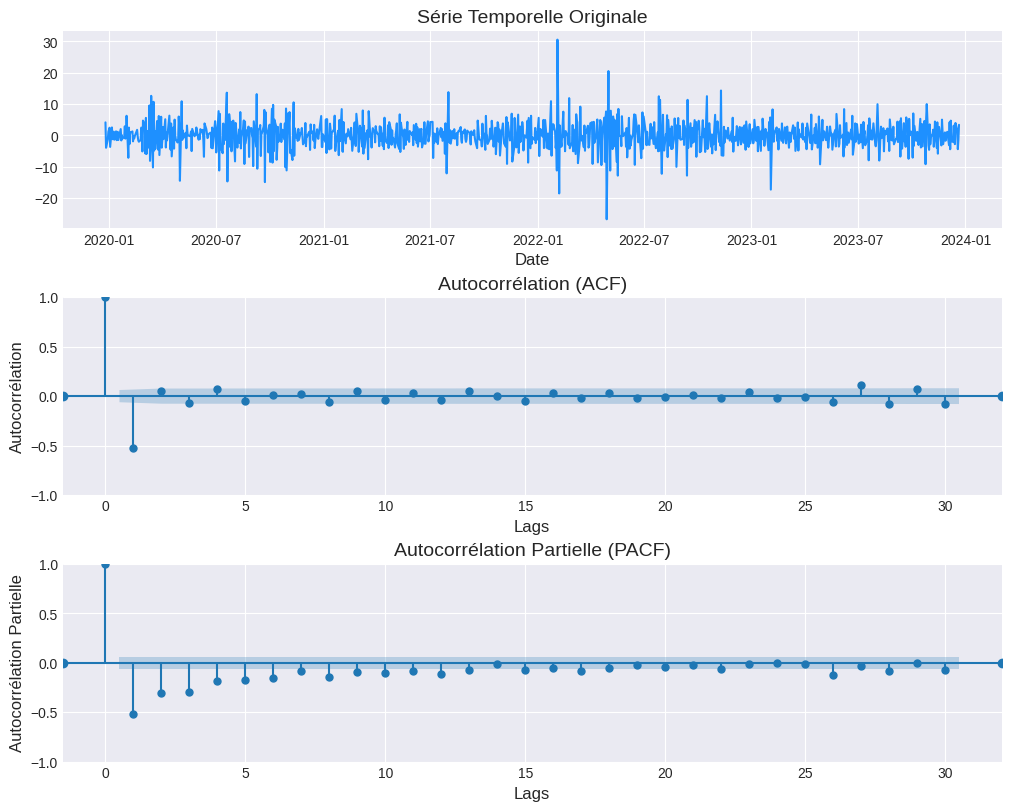

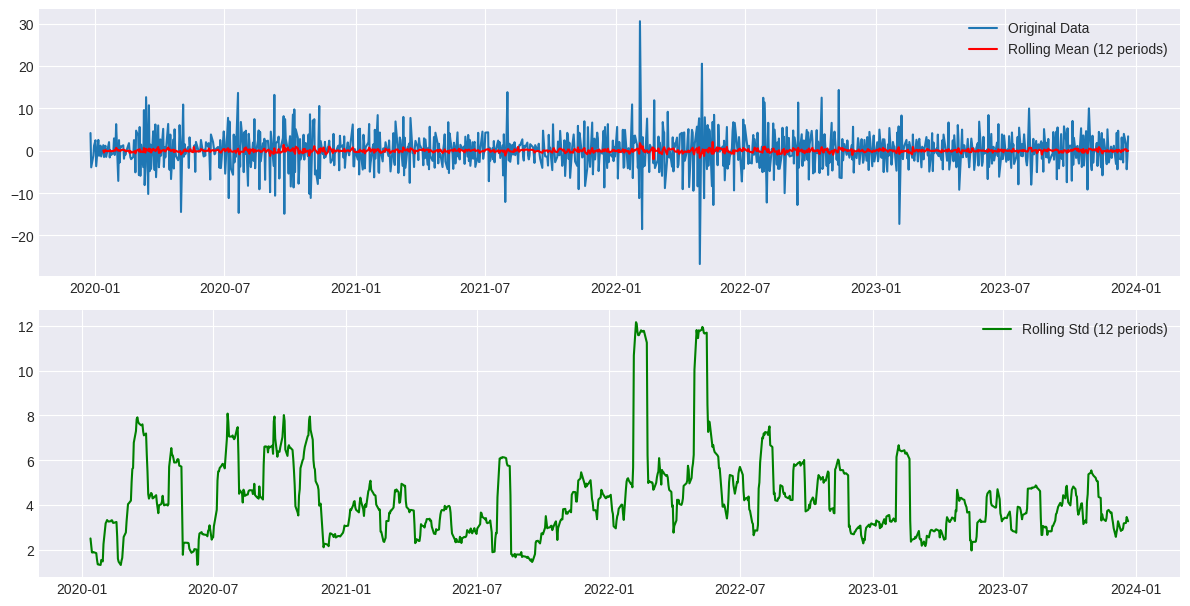

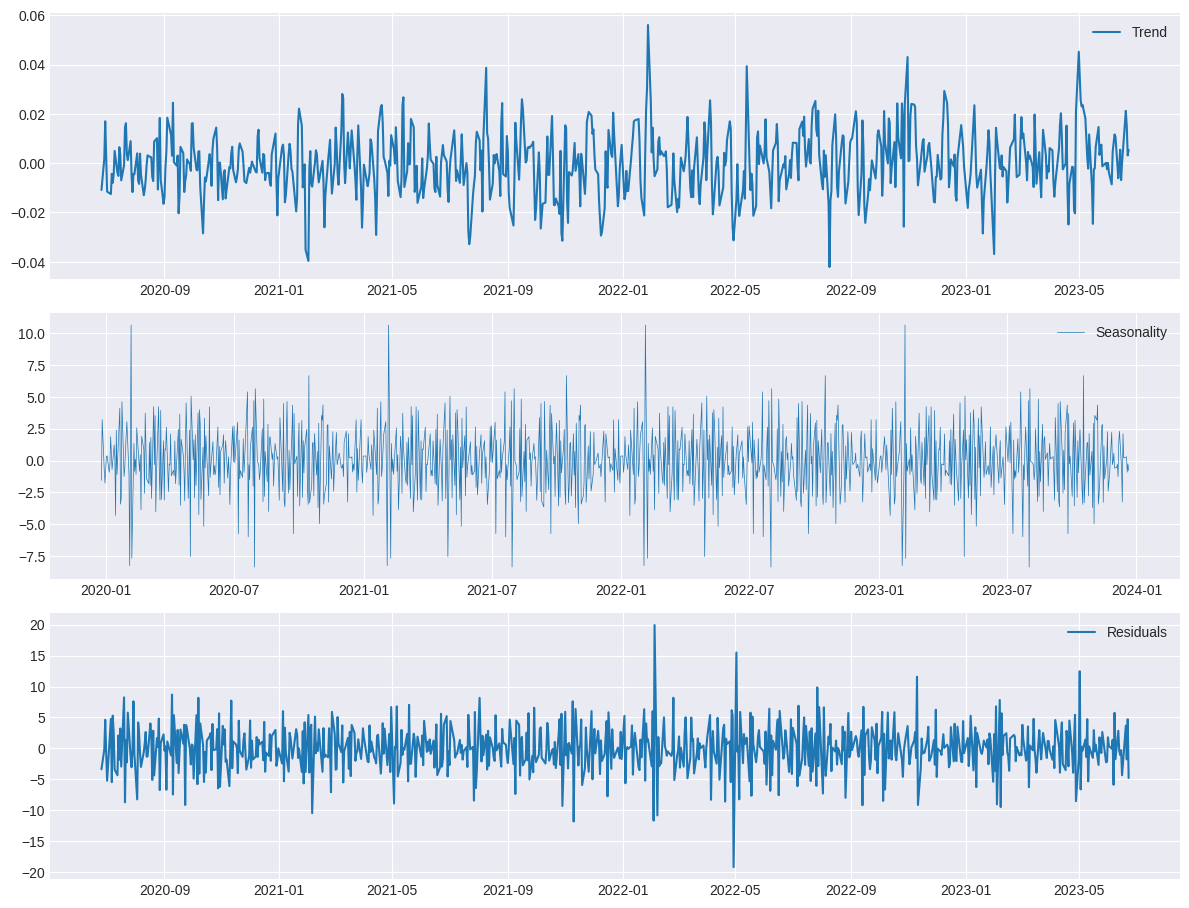

In [18]:
amazon_data_diff_2 = amazon_data_diff_d.diff().dropna()

adf_test = adfuller(amazon_data_diff_2, autolag='AIC')
print(f'ADF Statistic for 2° differenced series: {adf_test[0]}')
print(f'p-value for 2° differenced series: {adf_test[1]}')

plot_time_series_analysis(amazon_data_diff_2)
plot_rolling_statistics(amazon_data_diff_2, window_size=12)
plot_seasonal_decomposition(amazon_data_diff_2,model='additive')



*   Pour d=2, l'ACF et PACF ne montreraient généralement pas de nouveaux insights significatifs après avoir établi la stationnarité avec d=1.

*   Avec d=2, le rolling standard deviation atteint une valeur de 12, ce qui est significativement plus élevé que pour d=1, où le rolling standard deviation ne dépasse pas 8.
*   En ce qui concerne les résidus, pour d=2 ils atteignent des valeurs extrêmes allant jusqu'à 20, comparativement à d=1 où les résidus ne dépassent pas 11. Des résidus plus élevés et plus volatils suggèrent que le modèle sur-différencié pourrait capter du bruit plutôt que de l'information signal, indiquant que la différenciation supplémentaire n'est pas justifiée et peut être néfaste.

**Ces observations renforcent l'idée que d=1 est plus approprié que d=2. La différenciation doit être utilisée avec parcimonie, en différenciant seulement jusqu'à ce que la série devienne stationnaire. Aller au-delà de cela ne fait qu'augmenter la variabilité et réduire la qualité des informations que la série peut fournir pour les prévisions futures. En règle générale, le modèle le plus simple qui rend la série stationnaire est souvent le meilleur choix, car il minimise le risque de sur-ajustement et préserve la dynamique naturelle des données.**



# L'ordre du terme AR(p)

Sur le graphique PACF, tous les lags tombent rapidement en dessous du seuil de signification. Cela suggère que l'ordre du terme AR est **p=0**

# L'ordre du terme MA(q)

Dans le graphique ACF, tous les lags tombent rapidement en dessous du seuil de signification. Cela indique que l'ordre du terme MA est **q=0**.

# Comment gérer si une série chronologique est légèrement sous-différenciée ou sur-différenciée ?

- Si la série est légèrement sous-différenciée, l’ajout d’un ou
plusieurs termes AR supplémentaires la compense généralement.

- De même, s’elle est légèrement trop différenciée, On essaye
d’ajouter un terme MA supplémentaire.

# Estimation du modèle ARIMA

## pour p=0, d=1, q=0

In [19]:
p, d, q = 0, 1, 0

In [20]:
%%capture
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(amazon_data['Close'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

## Trouver le p et q pour le minimum AIC

In [21]:
#!pip install pmdarima
import pmdarima as pm

In [22]:
%%capture
# Range for p and q
p_values = range(0, 3)
q_values = range(0, 3)

# Initialize variables to store the best model and criteria
best_model_aic = None
best_model_bic = None
best_aic = float('inf')
best_bic = float('inf')

# Loop through orders
for p in p_values:
    for q in q_values:
        model = ARIMA(amazon_data['Close'], order=(p, 1, q))
        fit_model = model.fit()
        aic = fit_model.aic
        bic = fit_model.bic
        print(f"Order: ({p}, 1, {q}), AIC: {aic:.4f}, BIC: {bic:.4f}")

        # Update best model if the current one has a lower BIC
        if bic < best_bic:
            best_model_bic = fit_model
            best_bic = bic

        # Update best model if the current one has a lower AIC
        if aic < best_aic:
            best_model_aic = fit_model
            best_aic = aic


In [23]:
print("\nBest Model Summary (AIC):")
print(best_model_aic.summary())

print("\nBest Model Summary (BIC):")
print(best_model_bic.summary())


Best Model Summary (AIC):
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1007
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2558.259
Date:                Fri, 12 Jan 2024   AIC                           5126.519
Time:                        13:15:24   BIC                           5151.087
Sample:                             0   HQIC                          5135.854
                               - 1007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6914      0.011   -159.798      0.000      -1.712      -1.671
ar.L2         -0.9693      0.010    -94.869      0.000      -0.989      -0.949
ma.L1          1.7076    

- Le modèle optimisé selon **l'AIC** est un ARIMA(2, 1, 2) a un AIC de 5126.519 et un BIC de 5151.087, indiquant un ajustement plus fin aux données d'entraînement qui pourrait potentiellement capturer une plus grande complexité dans la structure de la série temporelle.
- Le modèle préféré selon **le BIC** est un ARIMA(0, 1, 0), ce qui est essentiellement une marche aléatoire sans composantes autorégressives ou de moyenne mobile supplémentaires. Avec un BIC plus bas de 5139.236, ce modèle est favorisé pour sa simplicité et sa parcimonie, ce qui peut souvent conduire à de meilleures performances de prévision en raison d'une moindre propension au surajustement.

# Tests de validation sur les résidus estimés du modèle ARIMA

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.diagnostic import  het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera

def validation_tests(residuals):
  sep = "\n--------------------------------------------------------\n"
  # Test de Ljung-Box pour l'autocorrélation des résidus
  ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
  print("Test de Ljung-Box:")
  print(ljung_box_test, "\n")

  print("H0  : Les résidus du modèle ne présentent pas d'autocorrélation.")
  if ljung_box_test["lb_pvalue"][10] > 0.05:
    print("p−value > 0.05 , alors nous ne rejetons pas l'hypothèse nulle.")
  else :
    print("p−value < 0.05 , alors nous rejetons l'hypothèse nulle.")

  print(sep)

  # Test de Breusch-Pagan pour l'hétéroscédasticité
  bp_test = het_breuschpagan(residuals, sm.add_constant(amazon_data['Close'])[1:].dropna())
  print("Test de Breusch-Pagan:")
  print('Lagrange Multiplier p-value:', bp_test[1], "\n")
  # Test de White pour l'hétéroscédasticité
  white_test = het_white(residuals, sm.add_constant(amazon_data['Close'])[1:].dropna())
  print("Test de White:")
  print('Test Statistic p-value:', white_test[1], "\n")

  print("H0  : la variance des résidus est constante (homoscédasticité).")
  if bp_test[1] > 0.05 and white_test[1] > 0.05 :
    print("dans les deux test : p−value > 0.05 , alors nous ne rejetons pas l'hypothèse nulle.")
  else :
    print("p−value < 0.05 , alors nous rejetons l'hypothèse nulle.")

  print(sep)

  # Test de Jarque-Bera pour la normalité des résidus
  jb_test = jarque_bera(residuals)
  print("Test de Jarque-Bera:")
  print('JB Statistic:', jb_test[0], 'p-value:', jb_test[1])

  print("H0  : Les résidus suivent une distribution normale.")
  if jb_test[1] > 0.05:
    print("p−value > 0.05 , alors nous ne rejetons pas l'hypothèse nulle.")
  else :
    print("p−value < 0.05 , alors nous rejetons l'hypothèse nulle.")


## Tests de validation sur les résidus estimés du modèle qui minimise l'AIC : ARIMA(2,1,2)

In [25]:
residuals_aic = best_model_aic.resid[1:]
validation_tests(residuals_aic)

Test de Ljung-Box:
     lb_stat  lb_pvalue
10  3.484421   0.967625 

H0  : Les résidus du modèle ne présentent pas d'autocorrélation.
p−value > 0.05 , alors nous ne rejetons pas l'hypothèse nulle.

--------------------------------------------------------

Test de Breusch-Pagan:
Lagrange Multiplier p-value: 0.6081730375249801 

Test de White:
Test Statistic p-value: 0.06544097877195035 

H0  : la variance des résidus est constante (homoscédasticité).
dans les deux test : p−value > 0.05 , alors nous ne rejetons pas l'hypothèse nulle.

--------------------------------------------------------

Test de Jarque-Bera:
JB Statistic: 796.3928512198348 p-value: 1.162758824062317e-173
H0  : Les résidus suivent une distribution normale.
p−value < 0.05 , alors nous rejetons l'hypothèse nulle.


## Tests de validation sur les résidus estimés du modèle qui minimise le BIC : ARIMA(0,1,0)

In [26]:
residuals_bic = best_model_bic.resid[1:]
validation_tests(residuals_bic)

Test de Ljung-Box:
     lb_stat  lb_pvalue
10  8.605849   0.569873 

H0  : Les résidus du modèle ne présentent pas d'autocorrélation.
p−value > 0.05 , alors nous ne rejetons pas l'hypothèse nulle.

--------------------------------------------------------

Test de Breusch-Pagan:
Lagrange Multiplier p-value: 0.6122664976834833 

Test de White:
Test Statistic p-value: 0.05784949536021828 

H0  : la variance des résidus est constante (homoscédasticité).
dans les deux test : p−value > 0.05 , alors nous ne rejetons pas l'hypothèse nulle.

--------------------------------------------------------

Test de Jarque-Bera:
JB Statistic: 703.3929406263005 p-value: 1.8203866342687895e-153
H0  : Les résidus suivent une distribution normale.
p−value < 0.05 , alors nous rejetons l'hypothèse nulle.


**Dans les deux modèles** : *Le test de Ljung-Box indique l'absence d'autocorrélation significative dans les résidus, permettant de les considérer comme du bruit blanc. Les tests de Breusch-Pagan et White confirment également que les résidus sont homoscédastiques, avec une variance constante. Toutefois, le test de Jarque-Bera révèle une non-normalité des résidus, suggérant une possible inadéquation du modèle ARIMA. Bien que le modèle capture bien la dépendance temporelle et maintienne une variance constante, cette déviation de la normalité pourrait impacter certaines analyses statistiques ou prédictions basées sur le modèle.*






## Tester avec différentes valeurs de p, d et q pour obtenir un modèle avec des résidus conformes à une distribution normale

In [27]:
%%capture
def check_normality(data):
  # Range for p and q
  p_values = range(0, 3)
  q_values = range(0, 3)
  d_values = range(1, 2)
  p_d_q_values = []
  for d in d_values:
    for p in p_values:
        for q in q_values:
          model = ARIMA(data, order=(p, d, q))
          fit_model = model.fit()

          residuals = fit_model.resid[1:]

          # Test de Jarque-Bera pour la normalité des résidus
          jb_test = jarque_bera(residuals)

          if jb_test[1] > 0.05:
            p_d_q_values.append(tuple(p,d,q))
  return p_d_q_values

p_d_q_values = check_normality(amazon_data['Close'])

if p_d_q_values != []:
  print("Les paramètres p, d et q qui résultent en des résidus distribués normalement sont les suivants :", p_d_q_values)
else :
  print("Il n'est pas possible d'obtenir un modèle ARIMA dont les résidus suivent une distribution normale.")


## Explorations de diverses combinaisons de p, d et q pour chaque année individuellement en vue d'obtenir un modèle présentant des résidus conformes à une distribution normale.

In [28]:
# Séparer la série temporelle en quatre années distinctes.
amazon_data_per_year = [ amazon_data['Close']["2019-12-22":"2020-12-22"], amazon_data['Close']["2020-12-22":"2021-12-22"], amazon_data['Close']["2021-12-22":"2022-12-22"], amazon_data['Close']["2022-12-22":"2023-12-22"] ]

In [29]:
%%capture
p_d_q_values_for_each_year = []

for data in amazon_data_per_year:
  # ajouter p, d et q du modèle ARIMA dont les résidus suivent une distribution normale pour chaque annee.
  p_d_q_values_for_each_year.append(check_normality(data))


if p_d_q_values_for_each_year != [[], [], [], []]:
  print("Les paramètres p, d et q qui résultent en des résidus distribués normalement sont les suivants :", p_d_q_values)
else :
  print("Il n'est pas possible d'obtenir un modèle ARIMA dont les résidus suivent une distribution normale pour la série temporelle d'Amazon pour chaque an.")

**Il est impossible d'obtenir des résidus conformes à une distribution normale avec le modèle ARIMA pour la série temporelle d'Amazon entre 2019-12-22 et 2023-12-22 en raison de la complexité inhérente des données financières, de la présence de facteurs externes influençant les prix des actions et de l'incapacité des modèles ARIMA à capturer de manière exhaustive les motifs complexes de ces données. Malgré des tentatives de spécification de différentes combinaisons de paramètres p, d et q, et pour des chaque annee; la nature imprévisible et non linéaire des données financières rend difficile l'ajustement d'un modèle ARIMA avec des résidus normalement distribués.**






## Analyse des Tracés Résiduels pour le Modèle ARIMA(2,1,2) qui minimise l'AIC

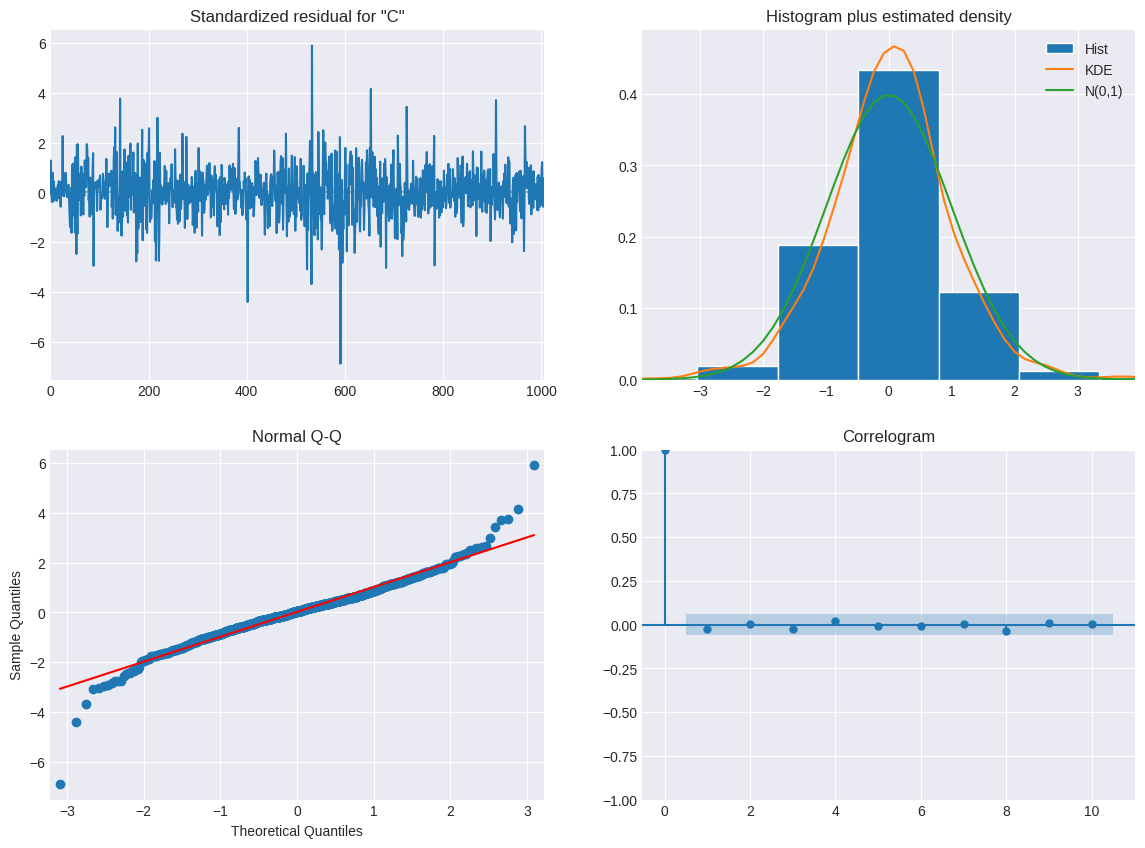

In [30]:
best_model_aic.plot_diagnostics(figsize=(14,10))
plt.show()

## Analyse des Tracés Résiduels pour le Modèle ARIMA(0,1,0) qui minimise le BIC

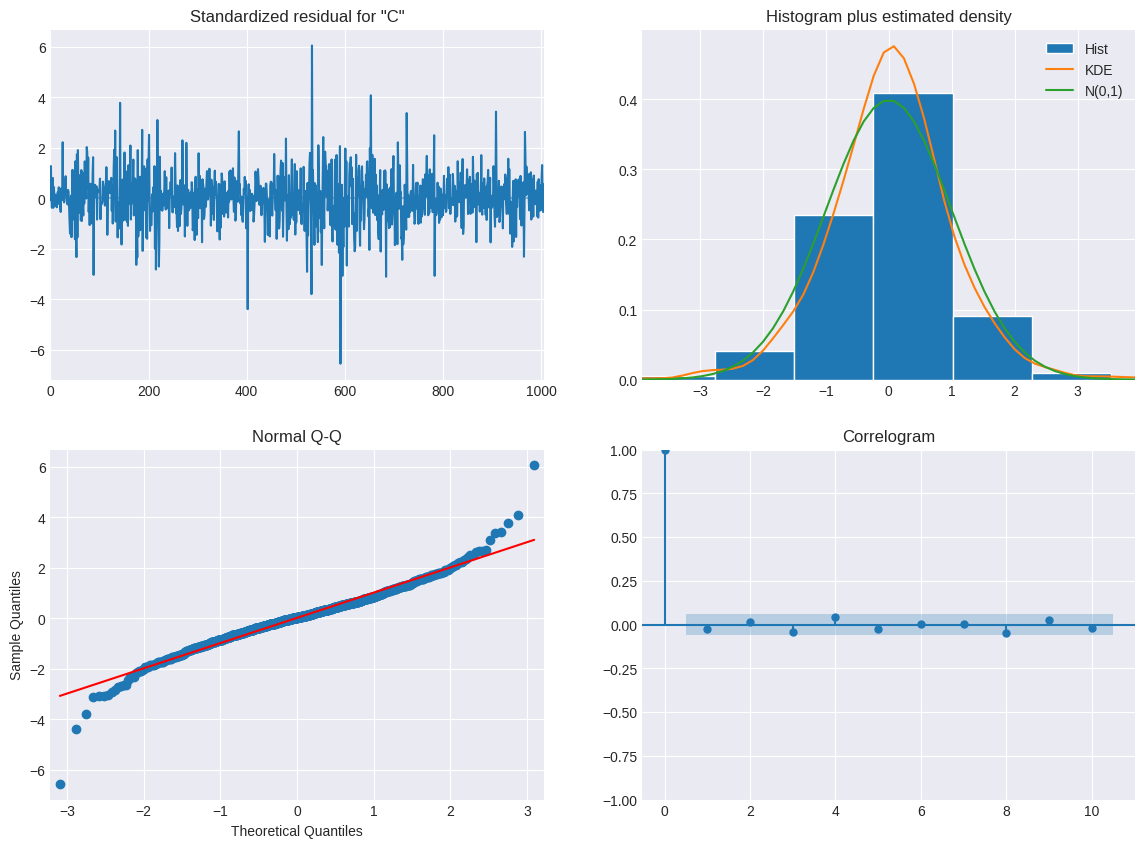

In [31]:
best_model_bic.plot_diagnostics(figsize=(14,10))
plt.show()

Les résultats des résidus pour les modèles ARIMA(0,1,0) et ARIMA(2,1,2) se montrent similaires et presque identiques, et ils confirment les conclusions des tests précédents. L'analyse des tracés résiduels révèle les éléments suivants :

- **Tracé des résidus standardisés :** Aucune tendance claire ou motif répétitif n'est observé dans les résidus standardisés, suggérant l'absence d'hétéroscédasticité évidente dans le modèle.

- **Histogramme et densité estimée :** L'histogramme des résidus et la densité estimée indiquent une légère déviation par rapport à une distribution normale, notamment dans les queues de la distribution. Ceci suggère la présence de valeurs extrêmes plus fréquentes que ce que l'on attendrait d'une distribution normale.

- **Graphique Q-Q normal :** Bien que les points de données du graphique Q-Q suivent largement la ligne théorique, des déviations aux extrémités suggèrent des queues plus lourdes que celles d'une distribution normale. Cela confirme les observations faites avec l'histogramme, indiquant que les résidus ne suivent pas une distribution parfaitement normale.

- **Corrélogramme :** Les barres d'autocorrélation restent dans les limites de la marge d'erreur, suggérant l'absence d'autocorrélation significative entre les résidus à différents décalages. Ceci suggère que le modèle a bien capturé la dépendance temporelle dans les données, excluant ainsi toute structure temporelle non expliquée dans les résidus.

# Conclusion de l'Analyse des Résidus


L'examen des résidus du modèle ARIMA(0,1,0) et ARIMA(2,1,2) offre des informations significatives sur la distribution des erreurs et leur comportement temporel. Voici les principales conclusions tirées de cette analyse :

- Absence de biais : Les résidus présentent une oscillation autour de zéro, ce qui suggère que le modèle n'introduit pas de biais systématique notable dans les prédictions.

- Autocorrélation des résidus : L'évaluation de la fonction d'autocorrélation (ACF) et du Test de Ljung-Box révèle l'absence d'autocorrélation significative dans les résidus. Cette constatation indique que le modèle a bien réussi à capturer la corrélation temporelle présente dans les données.

- Stabilité de la variance : Les résultats des tests de Breusch-Pagan et de White confirment l'homoscédasticité des résidus, ce qui signifie que la variance des résidus demeure relativement constante au fil du temps.

- Normalité des résidus : En revanche, le test de Jarque-Bera, l'histogramme et le graphique Q-Q révèlent que les résidus ne suivent pas une distribution normale. Ils mettent en évidence une distribution des résidus qui s'écarte légèrement de la normalité, notamment en ce qui concerne l'asymétrie et les queues lourdes.

# La Sélection du modèle ARIMA(0,1,0)

L'analyse des résidus indique que les modèles ARIMA(2,1,2) et ARIMA(0,1,0) sont similaires et pratiquement équivalents, à une différence près : le premier minimise l'AIC, tandis que le deuxième minimise le BIC. Dans le modèle ARIMA(0,1,0), l'AIC est de 5134.322, tandis que dans le modèle ARIMA(2,1,2), l'AIC est de 5126. La différence entre ces deux valeurs est de 8.322, soit environ 0.15% de la valeur de l'AIC du modèle ARIMA(2,1,2). Cette différence est négligeable et suggère que le modèle plus simple ARIMA(0,1,0) offre une qualité d'ajustement comparable à celle du modèle plus complexe avec p=2 et q=2, tout en étant plus parcimonieux. Par conséquent, on peut considérer que la différence de performance entre ces deux modèles est insignifiante, ce qui favorise **le choix du modèle ARIMA(0,1,0)** en raison de sa simplicité et de son efficacité.

# le modèle ARIMA optimal à l’aide de validation croisée imbriquée de séries chronologiques (Out-of-Time Cross validation)

In [52]:
# Ensure that the index is set to datetime and sort it just in case
amazon_data.index = pd.to_datetime(amazon_data.index)
amazon_data = amazon_data.sort_index()

# Resample the data to daily frequency and forward fill any missing values
amazon_data = amazon_data.asfreq('D', method='ffill')

In [32]:
%%capture
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np

# Ensure that the index is set to datetime and sort it just in case
amazon_data.index = pd.to_datetime(amazon_data.index)
amazon_data = amazon_data.sort_index()

# Resample the data to daily frequency and forward fill any missing values
amazon_data = amazon_data.asfreq('D', method='ffill')

# Définir les paramètres ARIMA à tester
p_values = [0, 1, 2, 3]
d_values = [1, 2]
q_values = [0, 1, 2, 3]
param_combinations = list(product(p_values, d_values, q_values))

# Accumulateurs pour les vraies valeurs et les prévisions
true_values = []
predictions = []

evaluation_metrics = []

# Configurer la validation croisée
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Parcourir toutes les combinaisons de paramètres ARIMA
for param in param_combinations:
    temp_true_values = []
    temp_predictions = []
    for train_index, test_index in tscv.split(amazon_data):
        train = amazon_data['Close'].iloc[train_index]
        test = amazon_data['Close'].iloc[test_index]
        # Entraîner le modèle ARIMA
        model = ARIMA(train, order=param)
        fitted_model = model.fit()
        # Faire des prévisions
        forecast = fitted_model.forecast(steps=len(test))
        # Accumuler les vraies valeurs et les prévisions
        temp_true_values.extend(test.values)
        temp_predictions.extend(forecast)

    # Calculer les métriques de précision pour cette combinaison de paramètres
    mse = mean_squared_error(temp_true_values, temp_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(temp_true_values, temp_predictions)
    mape = np.mean(np.abs((np.array(temp_true_values) - np.array(temp_predictions)) / np.array(temp_true_values))) * 100

    # Stocker les métriques pour cette combinaison de paramètres
    evaluation_metrics.append((param, mse, rmse, mae, mape))


In [33]:
evaluation_metrics = sorted(evaluation_metrics, key=lambda x: x[2])

In [34]:
print(f"La meilleure combinaison de paramètres basée sur la moyenne des RMSE est : {evaluation_metrics[0][0]} avec \n RMSE moyen de : {evaluation_metrics[0][2]} \n MSE moyen de : {evaluation_metrics[0][1]} \n MAE moyen de : {evaluation_metrics[0][3]} \n MAPE moyen de : {evaluation_metrics[0][4]} ")

La meilleure combinaison de paramètres basée sur la moyenne des RMSE est : (0, 1, 0) avec 
 RMSE moyen de : 26.282508349223306 
 MSE moyen de : 690.7702451269928 
 MAE moyen de : 20.007969747158725 
 MAPE moyen de : 16.816136739641898 


**Résultats de la validation croisée imbriquée :**

Après avoir effectué une série de tests de validation croisée sur les données des prix de clôture d'Amazon, nous avons identifié le modèle ARIMA(0,1,0) comme étant le plus adapté pour nos données. Avec un RMSE de 26.28, ce modèle, qui se base uniquement sur la différenciation pour rendre la série temporelle stationnaire, s'avère être le plus précis parmi ceux que nous avons examinés. Cela suggère que les fluctuations passées des prix ne fournissent pas d'indications fiables pour les prévisions futures au-delà de la tendance générale capturée par la différenciation. En d'autres termes, ***les mouvements futurs des prix pourraient être considérés comme imprévisibles à partir des données historiques***, ce qui est une caractéristique typique d'un marché efficient.

# Calcul de prévisions hors échantillon du **22/11/2023** au **22/12/2023**

In [71]:
import pandas as pd
import numpy as np

def forcast(train, test, order):
  # Forecast
  train = pd.DataFrame({'value': train.values}, index=np.arange(len(train)))
  test = pd.DataFrame({'value': test.values}, index=np.arange(len(train),len(test)+len(train)))
  n_forecast = len(test)

  model = ARIMA(train, order=order)

  fitted = model.fit()
  forecast_result = fitted.get_forecast(steps=n_forecast, alpha=0.05)

  # Extract forecast values, standard errors, and confidence intervals
  fc = forecast_result.predicted_mean
  conf = forecast_result.conf_int()

  mse = ((np.array(fc)-np.array(test)) ** 2).mean()
  print("MSE : ",mse)

  # Make as pandas series
  fc_series = pd.Series(fc, index=test.index[:n_forecast])
  lower_series = pd.Series(conf.iloc[:, 0], index=test.index[:n_forecast])
  upper_series = pd.Series(conf.iloc[:, 1], index=test.index[:n_forecast])

  # Plot
  plt.figure(figsize=(12, 5), dpi=100)
  plt.plot(train[1200:], label='training')
  plt.plot(test, label='actual')
  plt.plot(fc_series, label='forecast')
  plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
  plt.title('Forecast vs Actuals')
  plt.legend(loc='upper left', fontsize=8)
  plt.show()
  #print(fc_series)


In [80]:
train = amazon_data['Close'][:"22/11/2023"]
test = amazon_data['Close']["22/11/2023":]
order = (0,1,0)

<ipython-input-80-9f4f88d9947b>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train = amazon_data['Close'][:"22/11/2023"]
<ipython-input-80-9f4f88d9947b>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  test = amazon_data['Close']["22/11/2023":]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


MSE :  7.81472526739041


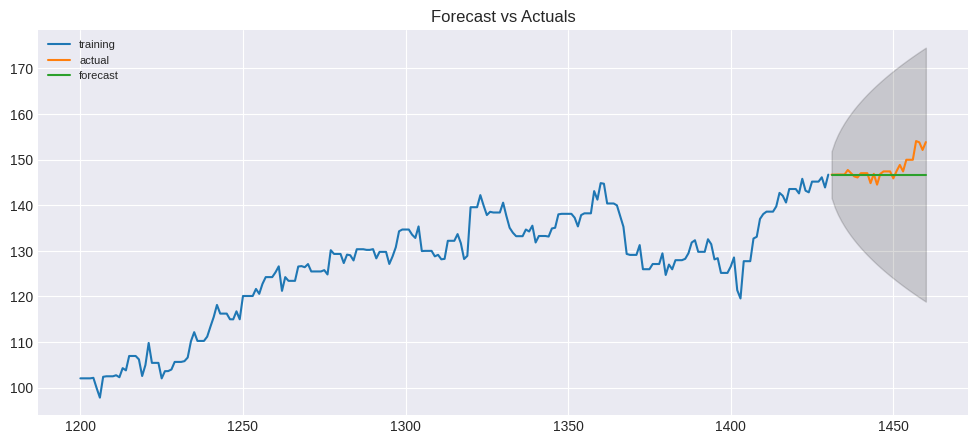

In [73]:
forcast(train, test, order)

Le graphique des prévisions du modèle ARIMA(0,1,0) pour les prix de clôture d'Amazon montre une divergence entre les valeurs prédites et les données réelles. Cela indique que le modèle, bien qu'il soit le plus précis parmi ceux testés, ne parvient pas à capturer la complexité des mouvements de prix sur le marché. Ce modèle repose uniquement sur la différenciation pour stabiliser la série, ce qui implique que les valeurs passées n'offrent pas une base solide pour prédire les futurs prix. Cette observation est cohérente avec l'hypothèse d'un marché efficient, où les informations sont pleinement reflétées dans les prix actuels, rendant ainsi les prévisions basées uniquement sur l'historique des prix peu fiables. Il serait peut-être judicieux d'explorer d'autres modèles qui peuvent intégrer des informations supplémentaires ou des dynamiques de marché plus complexes pour améliorer les prévisions futures.

# ARIMA Avec une saisonnalité hebdomadaire

## pour l'ordre (0,1,0)

<ipython-input-85-84bb358baa4e>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train = amazon_data['Close'][:"22/11/2023"]
<ipython-input-85-84bb358baa4e>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  test = amazon_data['Close']["22/11/2023":]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


MSE :  21.424604676018273


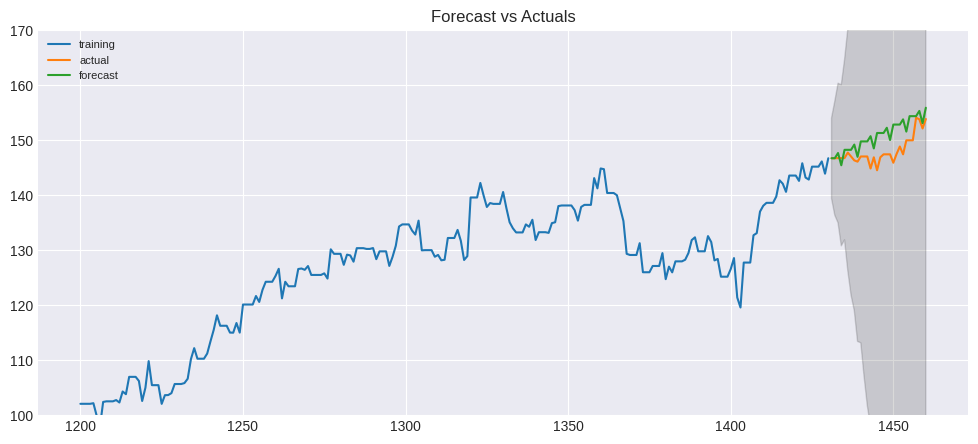

In [85]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = amazon_data['Close'][:"22/11/2023"]
test = amazon_data['Close']["22/11/2023":]

train = pd.DataFrame({'value': train.values}, index=np.arange(len(train)))
test = pd.DataFrame({'value': test.values}, index=np.arange(len(train),len(test)+len(train)))
n_forecast = len(test)

model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 5))

fitted = model.fit()
forecast_result = fitted.get_forecast(steps=n_forecast, alpha=0.05)

# Extract forecast values, standard errors, and confidence intervals
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int()

mse = ((np.array(fc)-np.array(test)) ** 2).mean()
print("MSE : ",mse)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index[:n_forecast])
lower_series = pd.Series(conf.iloc[:, 0], index=test.index[:n_forecast])
upper_series = pd.Series(conf.iloc[:, 1], index=test.index[:n_forecast])

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train[1200:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.ylim(100, 170)
plt.show()

Le modèle SARIMAX avec order=(0, 1, 0) et seasonal_order=(0, 1, 0, 5) suit effectivement la tendance de la série temporelle. Cela signifie que même sans composants autorégressifs ou de moyenne mobile, le modèle est capable de prédire la direction générale que prend la série temporelle, en partie grâce à la différenciation qui aide à stabiliser la moyenne sur le temps. La composante saisonnière avec une période de 5 permet au modèle de prendre en compte et d'ajuster les prévisions en fonction des schémas qui se répètent tous les 5 intervalles de temps.

pour l'ordre (2,1,2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


MSE :  6.902158984901643


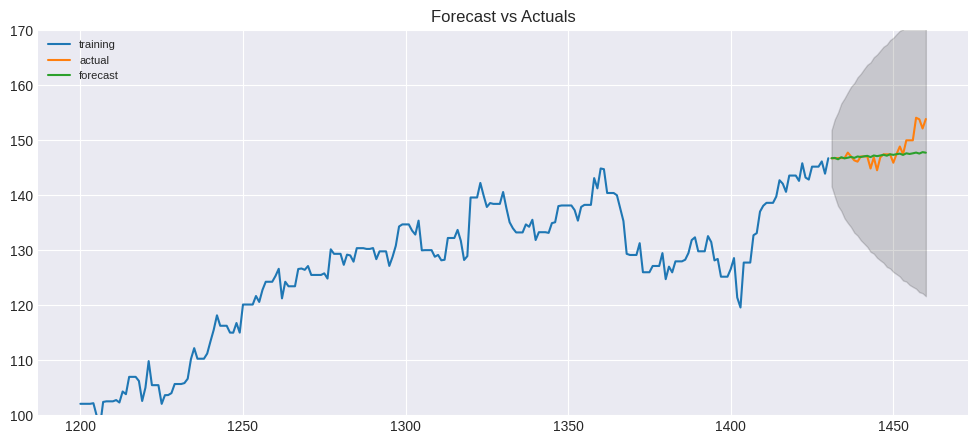

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = amazon_data['Close'][:"22/11/2023"]
test = amazon_data['Close']["22/11/2023":]

train = pd.DataFrame({'value': train.values}, index=np.arange(len(train)))
test = pd.DataFrame({'value': test.values}, index=np.arange(len(train),len(test)+len(train)))
n_forecast = len(test)

model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(2, 1, 2, 5))

fitted = model.fit()
forecast_result = fitted.get_forecast(steps=n_forecast, alpha=0.05)

# Extract forecast values, standard errors, and confidence intervals
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int()

mse = ((np.array(fc)-np.array(test)) ** 2).mean()
print("MSE : ",mse)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index[:n_forecast])
lower_series = pd.Series(conf.iloc[:, 0], index=test.index[:n_forecast])
upper_series = pd.Series(conf.iloc[:, 1], index=test.index[:n_forecast])

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train[1200:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.ylim(100, 170)
plt.show()

Le modèle SARIMAX avec order=(2, 1, 2) et seasonal_order=(2, 1, 2, 5) ne capture pas la tendance de la série temporelle comme souhaité. Par conséquent, il semble judicieux de choisir le modèle SARIMAX plus simple avec order=(0, 1, 0) et seasonal_order=(0, 1, 0, 5), qui a démontré une meilleure capacité à suivre la tendance de la série.

# Auto Arima Forecast

In [11]:
#!pip install pmdarima

# Importer les bibliothèques nécessaires
import pmdarima as pm
import pandas as pd
#import io

# Utiliser la fonction auto_arima pour ajuster automatiquement le modèle ARIMA
model = pm.auto_arima(amazon_data['Close'],
                      start_p=1, start_q=1,  # Choix initial des paramètres p et q
                      test='adf',           # Utiliser le test adf pour déterminer 'd' de manière optimale
                      max_p=3, max_q=3,      # Valeurs maximales pour p et q
                      m=1,                   # Fréquence de la série temporelle
                      d=None,                # Laisser le modèle déterminer 'd'
                      seasonal=False,        # Pas de saisonnalité
                      start_P=0,
                      D=0,
                      trace=True,            # Afficher les étapes du processus de recherche
                      error_action='ignore',  # Ignorer les erreurs pour éviter l'interruption du processus
                      suppress_warnings=True, # Supprimer les avertissements pour une sortie plus propre
                      stepwise=False,        # Désactiver l'approche pas à pas pour explorer l'ensemble complet des combinaisons
                      information_criterion='aic',  # Critère d'information (AIC) pour la sélection du modèle
                      approximation=False,   # Désactiver l'approximation pour évaluer toutes les combinaisons
                      suppress_stdout=False, # Activer l'affichage de la sortie pour voir les résultats
                      p_values=[1, 2, 3],     # Liste des valeurs de p à considérer
                      q_values=[1, 2, 3])     # Liste des valeurs de q à considérer

# Afficher un résumé du modèle ajusté
print(model.summary())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5135.897, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5137.152, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5138.996, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5139.288, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5137.132, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5137.373, Time=1.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5139.112, Time=2.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5139.334, Time=1.66 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5138.921, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5139.143, Time=1.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.50 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5139.041, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5139.625, Time=1.56 sec
 ARIMA(3

L'utilisation de la fonction auto.arima a abouti à la sélection du modèle ARIMA(0,1,1) pour la série temporelle des prix de clôture d'Amazon. Ce modèle indique qu'après avoir ajusté pour les tendances en différenciant les données une fois (d=1), le meilleur moyen de prédire le prix suivant est de regarder l'erreur de la prévision précédente (q=1) sans se référer à des valeurs passées (p=0). En termes simples, le modèle suggère que les prix d'Amazon sont influencés par les variations récentes plutôt que par des tendances ou cycles à long terme.